In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean

In [2]:
from sqlalchemy import create_engine
conn = create_engine('sqlite:///E:/Envirocar/myapp/envirocar.db')

In [3]:
date = '2017-07-11'
start_time = date + " " + "00:00:00.000000"
end_time = date + " " + "23:59:59.999999"
query = 'SELECT * FROM VehicleData WHERE Time >= ? and Time <= ?'

data = pd.read_sql_query(query, conn, params=(start_time, end_time),parse_dates=['Time'])

In [90]:
def extract_date_data(date):
    start_time = date + " " + "00:00:00.000000"
    end_time = date + " " + "23:59:59.999999"
    query = 'SELECT * FROM DrivingData WHERE Time >= ? and Time <= ?'
    data = pd.read_sql_query(query, conn, params=(start_time, end_time), parse_dates=['Time'])
    return data    

In [59]:
time = data.Time[data.TripID == 1].values
len(time)
#timedelta = time.diff()
#timedelta.dtype

46340

In [65]:
from scipy import integrate
speed = data[data.TripID == 1]['Vehicle Speed Sensor'].values
distance = integrate.cumtrapz(speed,x=time)
distance

array([              0,               0,               0, ...,
       195576504000000, 195576504000000, 195576504000000],
      dtype='timedelta64[ns]')

In [43]:
def average_speed_of_trips(dateframe):
    average_speeds = {}
    trips = list(set(dateframe.TripID.values))
    for trip in trips :
        speed_values = dateframe[dateframe.TripID == trip]['Vehicle Speed Sensor'].values
        av_speed = round(mean(speed_values),2)
        average_speeds[trip] = av_speed
    
    return average_speeds
        
    

In [91]:
average_speed_of_trips(data)

{1: 49.58, 2: 80.62}

In [66]:
top = max(data['Vehicle Speed Sensor'].values)
top

198.0

In [67]:
def max_speeds_per_trip(dateframe):
    max_speeds = {}
    trips = list(set(dateframe.TripID.values))
    for trip in trips :
        top_speed = max(dateframe[dateframe.TripID == trip]['Vehicle Speed Sensor'].values)
        max_speeds[trip] = top_speed
        
    return max_speeds

In [68]:
max_speeds_per_trip(data)

{1: 126.0, 2: 198.0}

In [72]:
sp = [0,0,7,6,6]
sp = [x for x in sp if x != 0]
min(sp)

6

In [73]:
def min_speeds_per_trip(dateframe):
    min_speeds = {}
    trips = list(set(dateframe.TripID.values))
    for trip in trips :
        speed_values = dateframe[dateframe.TripID == trip]['Vehicle Speed Sensor'].values
        reduced_speed_values = [x for x in speed_values if x != 0]
        bottom_speed = min(reduced_speed_values)
        min_speeds[trip] = bottom_speed
        
    return min_speeds

In [74]:
min_speeds_per_trip(data)

{1: 1.0, 2: 1.0}

In [140]:
trip_data = data[data.TripID == 1]
df = trip_data[trip_data['Vehicle Speed Sensor'] == 0]
rpm = df[df['Engine RPM'] > 0]
time = rpm.Time.values
time

array(['2017-07-05T07:16:56.006000000', '2017-07-05T07:16:56.095000000',
       '2017-07-05T07:16:56.185000000', ...,
       '2017-07-05T08:22:15.615000000', '2017-07-05T08:22:15.704000000',
       '2017-07-05T08:22:15.794000000'], dtype='datetime64[ns]')

In [157]:
def idle_engine_time(speed_array):
    speed_values = speed_array
    idle_time_periods = []
    if (all(x == 0 for x in speed_values) and len(speed_values) > 0):
        idle_time_periods.append(5)
    
    #print(idle_time_periods)    
    return idle_time_periods

In [163]:
trip_data = data[data.TripID == 1]
tri_data = trip_data.set_index('Time')
trip_data = tri_data[tri_data['Vehicle Speed Sensor'] == 0]
trip_data = trip_data[trip_data['Engine RPM'] > 0]
trip_data = (trip_data['Vehicle Speed Sensor'].resample('5T').apply(idle_engine_time)).sum()

In [164]:
trip_data

35.0

In [ ]:
trip_data = data[data.TripID == 1]
speed_val = trip_data['Vehicle Speed Sensor'].values
mpg_val = [x * 7.718 * 0.354 for x in speed_val]
MPG = mean(mpg_val)


In [106]:
data.Time.head(1)

0   2017-07-05 07:16:31.257
Name: Time, dtype: datetime64[ns]

In [110]:
dt = ((data.Time.tail(1).values - data.Time.head(1).values)[0])
time = round(((trip_data.Time.tail(1).values - trip_data.Time.head(1).values)[0])/np.timedelta64(1,'h'),2)
time

12.94

In [111]:
e_load = [x/2.55 for x in data['Vehicle Speed Sensor'].values]

Index(['Time', 'Engine Coolant Temperature',
       'Intake Manifold Absolute Pressure', 'Engine RPM',
       'Vehicle Speed Sensor', 'Intake Air Temperature',
       'Air Flow Rate from Mass Flow Sensor', 'Absolute Throttle Position',
       'Ambient Air Temperature', 'Accelerator Pedal Position D',
       'Accelerator Pedal Position E', 'TripID'],
      dtype='object')

In [124]:
import pickle

In [135]:
li = [2,3,4]
li.count

<function list.count>

In [174]:
trip_data = data[data.TripID == 1]
throttle_change_rate = np.diff(trip_data['Absolute Throttle Position'].values) 
print(len(throttle_change_rate))
es_change_rate = np.diff(trip_data['Engine RPM'].values)
engine_load = [x/2.55 for x in trip_data['Vehicle Speed Sensor'].values]
vs_change_rate =  np.diff(trip_data['Vehicle Speed Sensor'].values)
mod_trip_data = pd.DataFrame({'Throttle_change_rate':throttle_change_rate,'ES_change_rate':es_change_rate,'VS_change_rate':vs_change_rate,
                            'Engine_load':engine_load[:-1]})
vehicle_speed_norm = [x/220 for x in trip_data['Vehicle Speed Sensor'].values[:len(trip_data['Vehicle Speed Sensor'].values)-1]]
engine_speed_norm = [x/8000 for x in trip_data['Engine RPM'].values[:len(trip_data['Engine RPM'].values)-1]]
df = pd.DataFrame({'vs_norm':vehicle_speed_norm,'es_norm':engine_speed_norm})
df['rr_of_vs_and_es'] = df.vs_norm/df.es_norm
df = df.dropna()
#rr_of_vs_and_es = [i/j for i,j in zip(vehicle_speed_norm, engine_speed_norm)]
#maximum_change_tp = max(throttle_change_rate)
#maximum_change_es = max(es_change_rate)
#throttle_position_norm = [x/maximum_change_tp for x in throttle_change_rate]
#len(throttle_position_norm)
#es_relative_norm = [x/maximum_change_es for x in es_change_rate]
#len(es_relative_norm)
#rr_of_tp_and_es = pd.Series([i/j for i,j in zip(throttle_position_norm, es_relative_norm)])
#feature_set = pd.DataFrame({'rr_of_vs_and_es':rr_of_vs_and_es,'rr_of_tp_and_es':rr_of_tp_and_es,'engine_load':engine_load[:-1]})
#feature_set = feature_set[~feature_set.isin([np.nan, np.inf, -np.inf]).any(1)]
#filename = r'E:\Envirocar\analysis\behaviour_analysis.sav'
#loaded_model = pickle.load(open(filename,'rb'))
#results = loaded_model.predict(feature_set).tolist()
#print(max(results, key=results.count))

17924


vs_norm            False
es_norm            False
rr_of_vs_and_es    False
dtype: bool

In [165]:
li = [1,1,2,2,2,2,4,7,8]
from statistics import mode
mode(li)

2

In [9]:
import pickle
trip_data = data[data.TripID == 1]
trip_data = trip_data.drop(['Time', 'Engine Coolant Temperature', 'Engine RPM',
       'Vehicle Speed Sensor', 'Intake Air Temperature','Absolute Throttle Position',
       'Ambient Air Temperature', 'Accelerator Pedal Position D',
       'Accelerator Pedal Position E', 'TripID'], axis=1)
print(trip_data.head())
filename = r'E:\Envirocar\analysis\anomaly_detection.sav'
loaded_model = pickle.load(open(filename,'rb'))
results = loaded_model.predict(trip_data).tolist()
normal = (results.count(1)/len(results))
anomalies = results.count(-1)/len(results)

print(normal, anomalies)

   Intake Manifold Absolute Pressure  Air Flow Rate from Mass Flow Sensor
0                               96.0                                10.52
1                               96.0                                10.52
2                               97.0                                10.52
3                               97.0                                10.52
4                               97.0                                10.52


e:\envirocar\venv\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


ValueError: Number of features of the model must match the input. Model n_features is 3 and input n_features is 2.

In [4]:
data.head() 

,Time,Engine Coolant Temperature,Intake Manifold Absolute Pressure,Engine RPM,Vehicle Speed Sensor,Intake Air Temperature,Air Flow Rate from Mass Flow Sensor,Absolute Throttle Position,Ambient Air Temperature,Accelerator Pedal Position D,Accelerator Pedal Position E,TripID
0,2017-07-11 08:24:30.585,24,96.0,934.0,0.0,33.0,10.52,82.7,17.0,14.1,14.5,1
1,2017-07-11 08:24:30.646,24,96.0,934.0,0.0,33.0,10.52,82.7,17.0,14.1,14.5,1
2,2017-07-11 08:24:30.706,24,97.0,934.0,0.0,33.0,10.52,82.7,17.0,14.1,14.5,1
3,2017-07-11 08:24:30.766,24,97.0,892.0,0.0,33.0,10.52,82.7,17.0,14.1,14.5,1
4,2017-07-11 08:24:30.855,24,97.0,892.0,0.0,33.0,10.52,82.7,17.0,14.1,14.5,1


In [8]:
trip_data = data[(data['Engine RPM'] == 0) & (data['Vehicle Speed Sensor'] == 0)]

In [9]:
trip_data.describe()

,Engine Coolant Temperature,Intake Manifold Absolute Pressure,Engine RPM,Vehicle Speed Sensor,Intake Air Temperature,Air Flow Rate from Mass Flow Sensor,Absolute Throttle Position,Ambient Air Temperature,Accelerator Pedal Position D,Accelerator Pedal Position E,TripID
count,3363.000000,3363.000000,3363.0,3363.0,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000
mean,88.704728,96.609872,0.0,0.0,97.570324,0.033431,85.256259,19.536426,16.516652,16.880761,1.110913
std,6.792799,10.363244,0.0,0.0,27.670353,0.225766,15.821051,0.998852,11.902741,11.730967,0.390103
min,41.000000,41.000000,0.0,0.0,-2.000000,0.000000,13.700000,19.000000,14.100000,14.100000,1.000000
25%,87.000000,99.000000,0.0,0.0,81.000000,0.000000,89.000000,19.000000,14.100000,14.500000,1.000000
50%,90.000000,99.000000,0.0,0.0,97.000000,0.000000,89.000000,19.000000,14.100000,14.500000,1.000000
75%,91.000000,99.000000,0.0,0.0,117.000000,0.000000,89.000000,20.000000,14.100000,14.500000,1.000000
max,94.000000,181.000000,0.0,0.0,149.000000,3.300000,89.000000,23.000000,85.100000,84.300000,3.000000


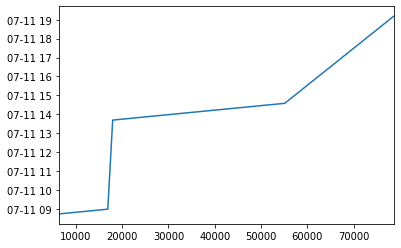

In [10]:
trip_data.Time.plot()